# Notebook Utils

This notebook contains helper functions and classes for use with OpenVINO™ Notebooks. The code is synchronized with the `notebook_utils.py` file in the same directory as this notebook.

There are four categories:

- [Files](#Files)
- [Images](#Images)
- [Videos](#Videos)
- [Visualization](#Visualization)
- [Checks and Alerts](#Checks-and-Alerts)

Each category contains a test cell that also shows how to use the functions in the section. 
#### Table of contents:

- [Files](#Files)
    - [Test File Functions](#Test-File-Functions)
- [Images](#Images)
    - [Convert Pixel Data](#Convert-Pixel-Data)
    - [Test Data Conversion Functions](#Test-Data-Conversion-Functions)
- [Videos](#Videos)
    - [Video Player](#Video-Player)
    - [Test Video Player](#Test-Video-Player)
- [Visualization](#Visualization)
    - [Segmentation](#Segmentation)
    - [Network Results](#Network-Results)
    - [Test Visualization Functions](#Test-Visualization-Functions)
- [Checks and Alerts](#Checks-and-Alerts)
    - [Test Alerts](#Test-Alerts)



In [1]:
# Install requirements
%pip install -q "openvino>=2023.1.0" opencv-python
%pip install -q pillow tqdm requests matplotlib

## Files
[back to top ⬆️](#Table-of-contents:)

Load an image, download a file, download an OpenVINO IR model, and create a progress bar to show download progress.

In [2]:
import os
import shutil
from PIL import Image
from notebook_utils import load_image, download_file, download_ir_model

In [3]:
??load_image

Signature: load_image(path: str) -> numpy.ndarray
Source:   
def load_image(path: str) -> np.ndarray:
    """
    Loads an image from `path` and returns it as BGR numpy array. `path`
    should point to an image file, either a local filename or a url. The image is
    not stored to the filesystem. Use the `download_file` function to download and
    store an image.

    :param path: Local path name or URL to image.
    :return: image as BGR numpy array
    """
    import cv2
    import requests

    if path.startswith("http"):
        # Set User-Agent to Mozilla because some websites block
        # requests with User-Agent Python
        response = requests.get(path, headers={"User-Agent": "Mozilla/5.0"})
        array = np.asarray(bytearray(response.content), dtype="uint8")
        image = cv2.imdecode(array, -1)  # Loads the image as BGR
    else:
        image = cv2.imread(path)
    return image
File:      ~/openvino_notebooks/notebooks/utils/notebook_utils.py
Type:      function

In [4]:
??download_file

Signature:
download_file(
    url: os.PathLike,
    filename: os.PathLike = None,
    directory: os.PathLike = None,
    show_progress: bool = True,
    silent: bool = False,
    timeout: int = 10,
) -> os.PathLike
Source:   
def download_file(
    url: PathLike,
    filename: PathLike = None,
    directory: PathLike = None,
    show_progress: bool = True,
    silent: bool = False,
    timeout: int = 10,
) -> PathLike:
    """
    Download a file from a url and save it to the local filesystem. The file is saved to the
    current directory by default, or to `directory` if specified. If a filename is not given,
    the filename of the URL will be used.

    :param url: URL that points to the file to download
    :param filename: Name of the local file to save. Should point to the name of the file only,
                     not the full path. If None the filename from the url will be used
    :param directory: Directory to save the file to. Will be created if it doesn't exist
           

In [5]:
??download_ir_model

Signature:
download_ir_model(
    model_xml_url: str,
    destination_folder: os.PathLike = None,
) -> os.PathLike
Source:   
def download_ir_model(model_xml_url: str, destination_folder: PathLike = None) -> PathLike:
    """
    Download IR model from `model_xml_url`. Downloads model xml and bin file; the weights file is
    assumed to exist at the same location and name as model_xml_url with a ".bin" extension.

    :param model_xml_url: URL to model xml file to download
    :param destination_folder: Directory where downloaded model xml and bin are saved. If None, model
                               files are saved to the current directory
    :return: path to downloaded xml model file
    """
    model_bin_url = model_xml_url[:-4] + ".bin"
    model_xml_path = download_file(model_xml_url, directory=destination_folder, show_progress=False)
    download_file(model_bin_url, directory=destination_folder)
    return model_xml_path
File:      ~/openvino_notebooks/notebooks/utils/noteboo

### Test File Functions
[back to top ⬆️](#Table-of-contents:)


In [6]:
model_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/002-example-models/segmentation.xml"
download_ir_model(model_url, "model")

assert os.path.exists("model/segmentation.xml")
assert os.path.exists("model/segmentation.bin")

model/segmentation.bin:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

In [7]:
url = "https://github.com/intel-iot-devkit/safety-gear-detector-python/raw/master/resources/Safety_Full_Hat_and_Vest.mp4"
if os.path.exists(os.path.basename(url)):
    os.remove(os.path.basename(url))
video_file = download_file(url)
print(video_file)
assert os.path.exists(video_file)

In [8]:
url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/README.md"
filename = "openvino_notebooks_readme.md"
if os.path.exists(filename):
    os.remove(filename)
readme_file = download_file(url, filename=filename)
print(readme_file)
assert os.path.exists(readme_file)

In [9]:
url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/README.md"
filename = "openvino_notebooks_readme.md"
directory = "temp"
video_file = download_file(
    url, filename=filename, directory=directory, show_progress=False, silent=True
)
print(readme_file)
assert os.path.exists(readme_file)
shutil.rmtree("temp")

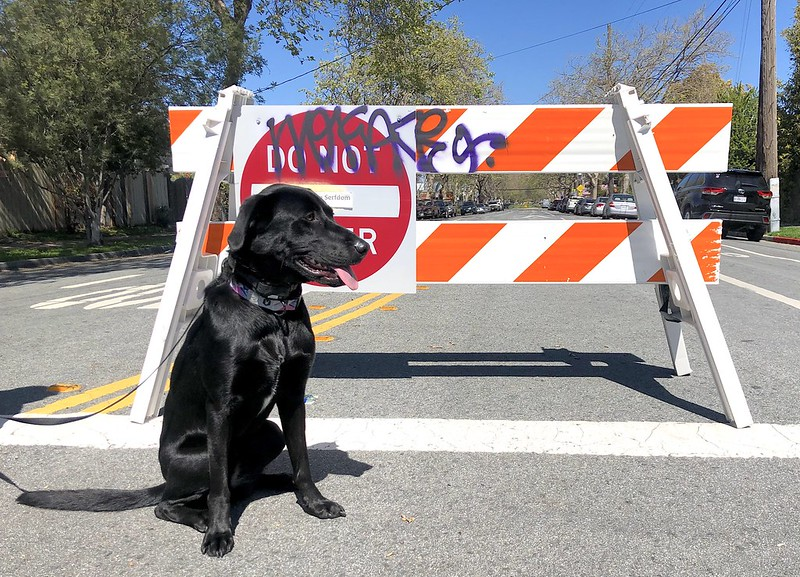

In [10]:
url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg"
image = load_image(url)
Image.fromarray(image[:, :, ::-1])

## Images
[back to top ⬆️](#Table-of-contents:)


### Convert Pixel Data
[back to top ⬆️](#Table-of-contents:)

Normalize image pixel values between 0 and 1, and convert images to `RGB` and `BGR`.

In [11]:
import numpy as np
from notebook_utils import normalize_minmax, to_rgb, to_bgr

In [12]:
??normalize_minmax

Signature: normalize_minmax(data)
Source:   
def normalize_minmax(data):
    """
    Normalizes the values in `data` between 0 and 1
    """
    if data.max() == data.min():
        raise ValueError(
            "Normalization is not possible because all elements of"
            f"`data` have the same value: {data.max()}."
        )
    return (data - data.min()) / (data.max() - data.min())
File:      ~/openvino_notebooks/notebooks/utils/notebook_utils.py
Type:      function

In [13]:
??to_bgr

Signature: to_bgr(image_data: numpy.ndarray) -> numpy.ndarray
Source:   
def to_bgr(image_data: np.ndarray) -> np.ndarray:
    """
    Convert image_data from RGB to BGR
    """
    import cv2
    return cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)
File:      ~/openvino_notebooks/notebooks/utils/notebook_utils.py
Type:      function

In [14]:
??to_rgb

Signature: to_rgb(image_data: numpy.ndarray) -> numpy.ndarray
Source:   
def to_rgb(image_data: np.ndarray) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    import cv2
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
File:      ~/openvino_notebooks/notebooks/utils/notebook_utils.py
Type:      function

### Test Data Conversion Functions
[back to top ⬆️](#Table-of-contents:)


In [15]:
test_array = np.random.randint(0, 255, (100, 100, 3))
normalized_array = normalize_minmax(test_array)

assert normalized_array.min() == 0
assert normalized_array.max() == 1

In [16]:
bgr_array = np.ones((100, 100, 3), dtype=np.uint8)
bgr_array[:, :, 0] = 0
bgr_array[:, :, 1] = 1
bgr_array[:, :, 2] = 2
rgb_array = to_rgb(bgr_array)

assert np.all(bgr_array[:, :, 0] == rgb_array[:, :, 2])

bgr_array_converted = to_bgr(rgb_array)
assert np.all(bgr_array_converted == bgr_array)

## Videos
[back to top ⬆️](#Table-of-contents:)


### Video Player
[back to top ⬆️](#Table-of-contents:)

A custom video player to fulfill FPS requirements. You can set target FPS and output size, flip the video horizontally or skip first N frames.

In [17]:
import cv2
from IPython.display import Image, clear_output, display
from notebook_utils import VideoPlayer

??VideoPlayer

Init signature: VideoPlayer(source, size=None, flip=False, fps=None, skip_first_frames=0)
Source:        
class VideoPlayer:
    """
    Custom video player to fulfill FPS requirements. You can set target FPS and output size,
    flip the video horizontally or skip first N frames.

    :param source: Video source. It could be either camera device or video file.
    :param size: Output frame size.
    :param flip: Flip source horizontally.
    :param fps: Target FPS.
    :param skip_first_frames: Skip first N frames.
    """

    def __init__(self, source, size=None, flip=False, fps=None, skip_first_frames=0):
        import cv2

        self.cv2 = cv2  # This is done to access the package in class methods
        self.__cap = cv2.VideoCapture(source)
        if not self.__cap.isOpened():
            raise RuntimeError(
                f"Cannot open {'camera' if isinstance(source, int) else ''} {source}"
            )
        # skip first N frames
        self.__cap.set(cv2.CAP_PROP_POS

### Test Video Player
[back to top ⬆️](#Table-of-contents:)


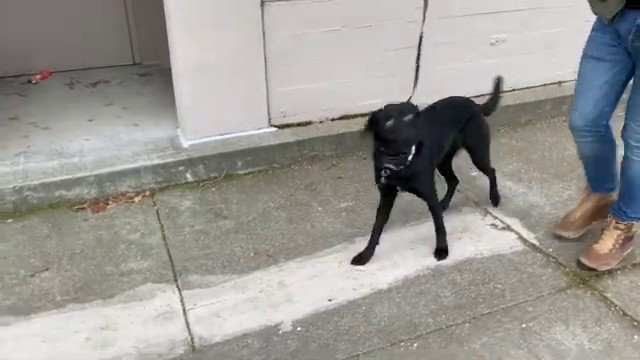

Finished


In [18]:
video = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"

player = VideoPlayer(video, fps=15, skip_first_frames=10)
player.start()
for i in range(50):
    frame = player.next()
    _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
    img = Image(data=encoded_img)
    clear_output(wait=True)
    display(img)

player.stop()
print("Finished")

## Visualization
[back to top ⬆️](#Table-of-contents:)


### Segmentation
[back to top ⬆️](#Table-of-contents:)

Define a `SegmentationMap NamedTuple` that keeps the labels and colormap for a segmentation project/dataset. Create `CityScapesSegmentation` and `BinarySegmentation SegmentationMaps`. Create a function to convert a segmentation map to an `RGB` image with a `colormap`, and to show the segmentation result as an overlay over the original image.

In [19]:
from notebook_utils import CityScapesSegmentation, BinarySegmentation, segmentation_map_to_image, segmentation_map_to_overlay

In [20]:
??Label

Object `Label` not found.


In [21]:
??SegmentationMap

Object `SegmentationMap` not found.


In [22]:
??CityScapesSegmentation

Type:        SegmentationMap
String form: SegmentationMap(labels=[Label(index=0, color=(128, 64, 128), name='road'), Label(index=1, color=(244, 35, 232), name='sidewalk'), Label(index=2, color=(70, 70, 70), name='building'), Label(index=3, color=(102, 102, 156), name='wall'), Label(index=4, color=(190, 153, 153), name='fence'), Label(index=5, color=(153, 153, 153), name='pole'), Label(index=6, color=(250, 170, 30), name='traffic light'), Label(index=7, color=(220, 220, 0), name='traffic sign'), Label(index=8, color=(107, 142, 35), name='vegetation'), Label(index=9, color=(152, 251, 152), name='terrain'), Label(index=10, color=(70, 130, 180), name='sky'), Label(index=11, color=(220, 20, 60), name='person'), Label(index=12, color=(255, 0, 0), name='rider'), Label(index=13, color=(0, 0, 142), name='car'), Label(index=14, color=(0, 0, 70), name='truck'), Label(index=15, color=(0, 60, 100), name='bus'), Label(index=16, color=(0, 80, 100), name='train'), Label(index=17, color=(0, 0, 230), na

In [23]:
print(f"cityscapes segmentation lables: \n{CityScapesSegmentation.get_labels()}")
print(f"cityscales segmentation colors: \n{CityScapesSegmentation.get_colormap()}")

cityscapes segmentation lables: 
['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'background']
cityscales segmentation colors: 
[[128  64 128]
 [244  35 232]
 [ 70  70  70]
 [102 102 156]
 [190 153 153]
 [153 153 153]
 [250 170  30]
 [220 220   0]
 [107 142  35]
 [152 251 152]
 [ 70 130 180]
 [220  20  60]
 [255   0   0]
 [  0   0 142]
 [  0   0  70]
 [  0  60 100]
 [  0  80 100]
 [  0   0 230]
 [119  11  32]
 [255 255 255]]


In [24]:
??BinarySegmentation

Type:        SegmentationMap
String form: SegmentationMap(labels=[Label(index=0, color=(255, 255, 255), name='background'), Label(index=1, color=(0, 0, 0), name='foreground')])
Length:      1
File:        ~/openvino_notebooks/notebooks/utils/notebook_utils.py
Source:     
class SegmentationMap(NamedTuple):
    labels: List

    def get_colormap(self):
        return np.array([label.color for label in self.labels])

    def get_labels(self):
        labelnames = [label.name for label in self.labels]
        if any(labelnames):
            return labelnames
        else:
            return None

In [25]:
print(f"binary segmentation lables: \n{BinarySegmentation.get_labels()}")
print(f"binary segmentation colors: \n{BinarySegmentation.get_colormap()}")

binary segmentation lables: 
['background', 'foreground']
binary segmentation colors: 
[[255 255 255]
 [  0   0   0]]


In [26]:
??segmentation_map_to_image

Signature:
segmentation_map_to_image(
    result: numpy.ndarray,
    colormap: numpy.ndarray,
    remove_holes: bool = False,
) -> numpy.ndarray
Source:   
def segmentation_map_to_image(
    result: np.ndarray, colormap: np.ndarray, remove_holes: bool = False
) -> np.ndarray:
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    :param result: A single network result after converting to pixel values in H,W or 1,H,W shape.
    :param colormap: A numpy array of shape (num_classes, 3) with an RGB value per class.
    :param remove_holes: If True, remove holes in the segmentation result.
    :return: An RGB image where each pixel is an int8 value according to colormap.
    """
    import cv2
    if len(result.shape) != 2 and result.shape[0] != 1:
        raise ValueError(
            f"Expected result with shape (H,W) or (1,H,W), got result with shape {result.shape}"
        )

    if len(np.unique(resul

In [27]:
??segmentation_map_to_overlay

Signature:
segmentation_map_to_overlay(
    image,
    result,
    alpha,
    colormap,
    remove_holes=False,
) -> numpy.ndarray
Source:   
def segmentation_map_to_overlay(image, result, alpha, colormap, remove_holes=False) -> np.ndarray:
    """
    Returns a new image where a segmentation mask (created with colormap) is overlayed on
    the source image.

    :param image: Source image.
    :param result: A single network result after converting to pixel values in H,W or 1,H,W shape.
    :param alpha: Alpha transparency value for the overlay image.
    :param colormap: A numpy array of shape (num_classes, 3) with an RGB value per class.
    :param remove_holes: If True, remove holes in the segmentation result.
    :return: An RGP image with segmentation mask overlayed on the source image.
    """
    import cv2
    if len(image.shape) == 2:
        image = np.repeat(np.expand_dims(image, -1), 3, 2)
    mask = segmentation_map_to_image(result, colormap, remove_holes)
    image_heigh

### Network Results
[back to top ⬆️](#Table-of-contents:)

Show network result image, optionally together with the source image and a legend with labels.

In [28]:
from notebook_utils import viz_result_image

??viz_result_image

Signature:
viz_result_image(
    result_image: numpy.ndarray,
    source_image: numpy.ndarray = None,
    source_title: str = None,
    result_title: str = None,
    labels: List[notebook_utils.Label] = None,
    resize: bool = False,
    bgr_to_rgb: bool = False,
    hide_axes: bool = False,
)
Source:   
def viz_result_image(
    result_image: np.ndarray,
    source_image: np.ndarray = None,
    source_title: str = None,
    result_title: str = None,
    labels: List[Label] = None,
    resize: bool = False,
    bgr_to_rgb: bool = False,
    hide_axes: bool = False,
):
    """
    Show result image, optionally together with source images, and a legend with labels.

    :param result_image: Numpy array of RGB result image.
    :param source_image: Numpy array of source image. If provided this image will be shown
                         next to the result image. source_image is expected to be in RGB format.
                         Set bgr_to_rgb to True if source_image is in BGR format

### Test Visualization Functions
[back to top ⬆️](#Table-of-contents:)


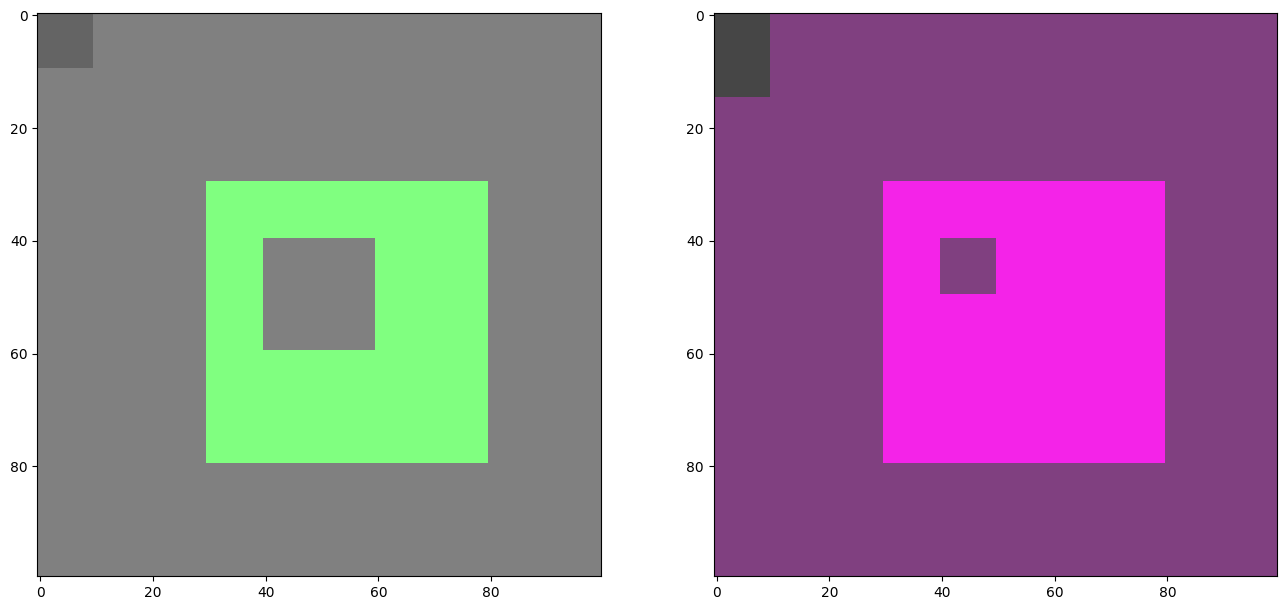

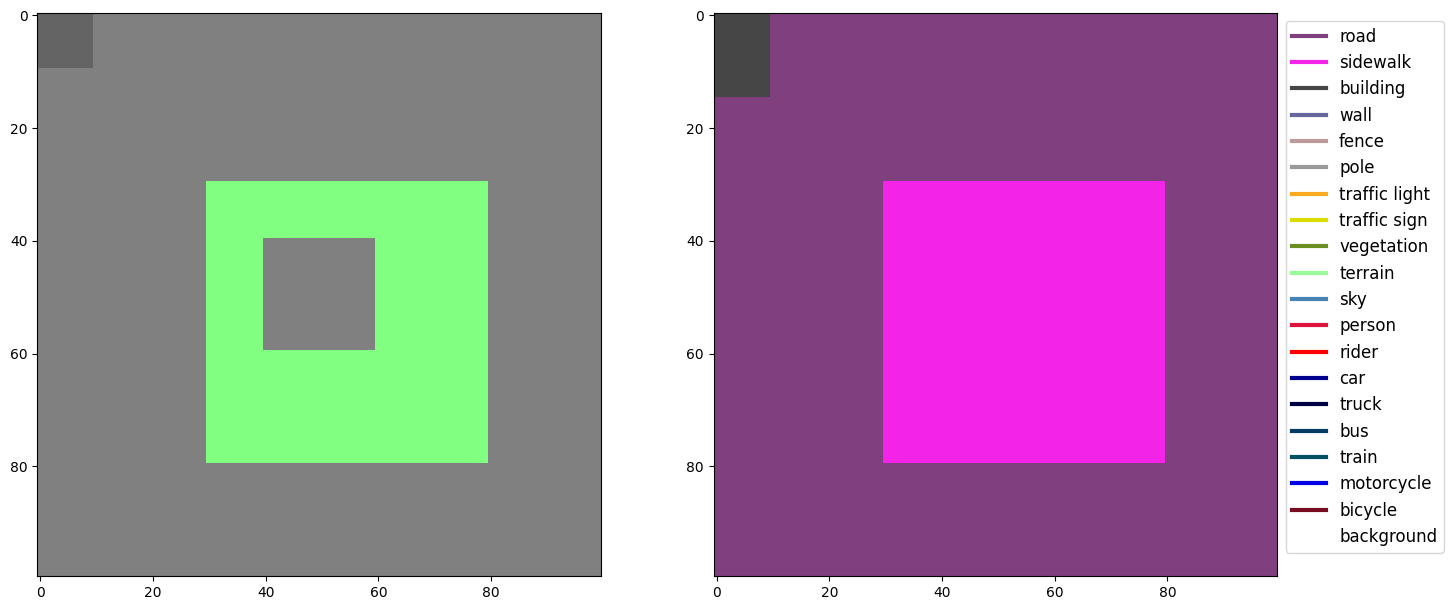

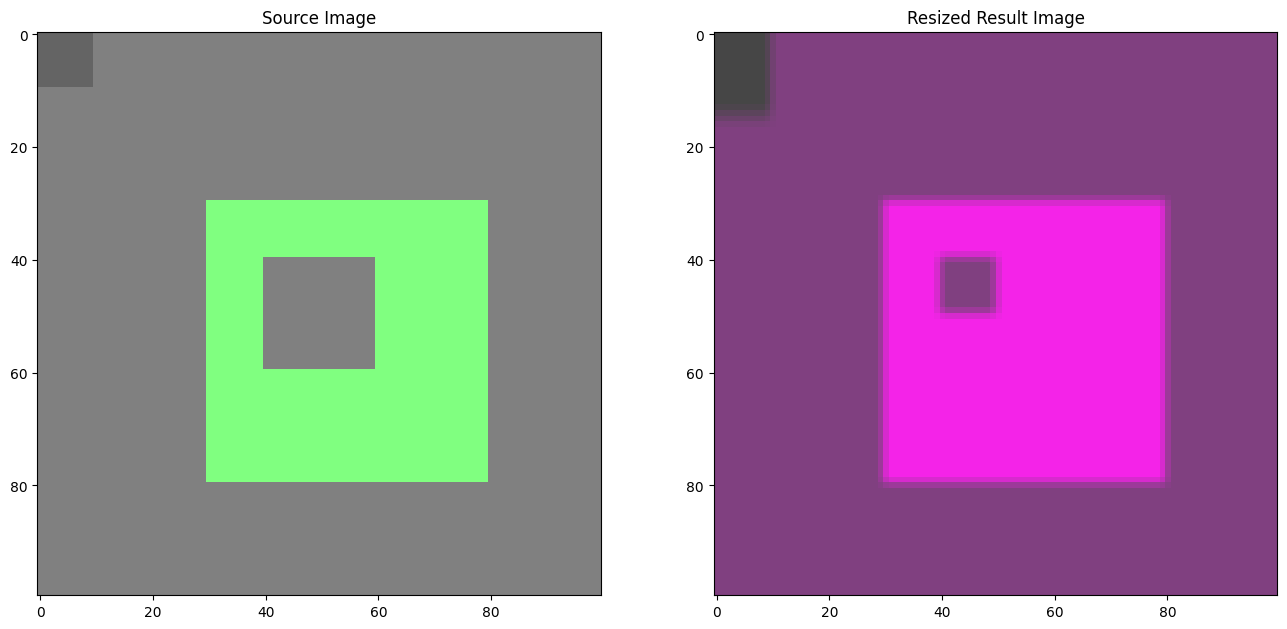

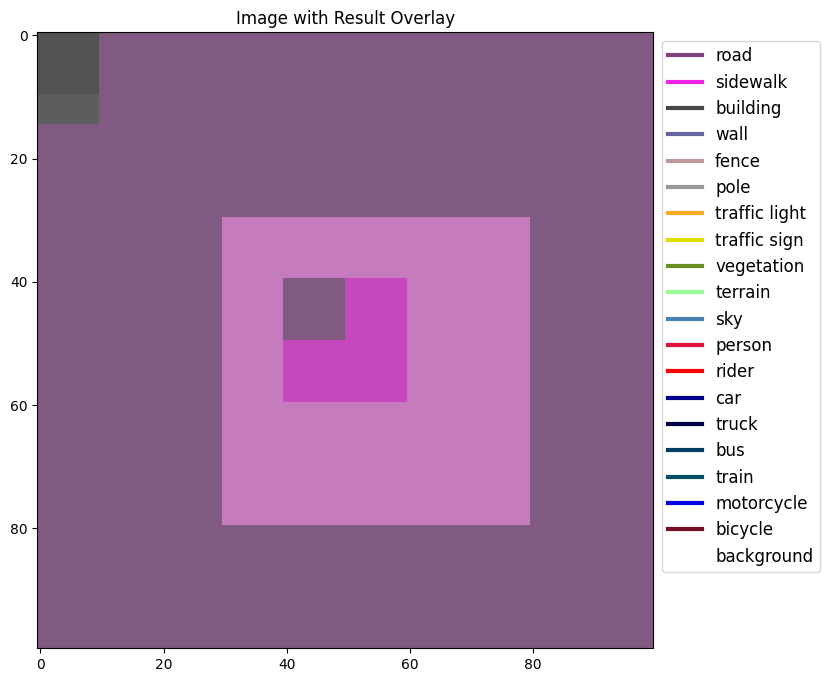

In [29]:
testimage = np.zeros((100, 100, 3), dtype=np.uint8)
testimage[30:80, 30:80, :] = [0, 255, 0]
testimage[0:10, 0:10, :] = 100
testimage[40:60, 40:60, :] = 128
testimage[testimage == 0] = 128


testmask1 = np.zeros((testimage.shape[:2]))
testmask1[30:80, 30:80] = 1
testmask1[40:50, 40:50] = 0
testmask1[0:15, 0:10] = 2

result_image_overlay = segmentation_map_to_overlay(
    image=testimage,
    result=testmask1,
    alpha=0.6,
    colormap=np.array([[0, 0, 0], [255, 0, 0], [255, 255, 0]]),
)
result_image = segmentation_map_to_image(testmask1, CityScapesSegmentation.get_colormap())
result_image_no_holes = segmentation_map_to_image(
    testmask1, CityScapesSegmentation.get_colormap(), remove_holes=True
)
resized_result_image = cv2.resize(result_image, (50, 50))
overlay_result_image = segmentation_map_to_overlay(
    testimage, testmask1, 0.6, CityScapesSegmentation.get_colormap(), remove_holes=False
)

fig1 = viz_result_image(result_image, testimage)
fig2 = viz_result_image(result_image_no_holes, testimage, labels=CityScapesSegmentation)
fig3 = viz_result_image(
    resized_result_image,
    testimage,
    source_title="Source Image",
    result_title="Resized Result Image",
    resize=True,
)
fig4 = viz_result_image(
    overlay_result_image,
    labels=CityScapesSegmentation,
    result_title="Image with Result Overlay",
)

display(fig1, fig2, fig3, fig4)

## Checks and Alerts
[back to top ⬆️](#Table-of-contents:)

Create an alert class to show stylized info/error/warning messages and a `check_device` function that checks whether a given device is available.

In [30]:
from notebook_utils import NotebookAlert, DeviceNotFoundAlert, check_device, check_openvino_version

In [31]:
??NotebookAlert

Init signature: NotebookAlert(message: str, alert_class: str)
Docstring:      Common base class for all non-exit exceptions.
Source:        
class NotebookAlert(Exception):
    def __init__(self, message: str, alert_class: str):
        """
        Show an alert box with the given message.

        :param message: The message to display.
        :param alert_class: The class for styling the message. Options: info, warning, success, danger.
        """
        self.message = message
        self.alert_class = alert_class
        self.show_message()

    def show_message(self):
        display(HTML(f"""<div class="alert alert-{self.alert_class}">{self.message}"""))
File:           ~/openvino_notebooks/notebooks/utils/notebook_utils.py
Type:           type
Subclasses:     DeviceNotFoundAlert

In [32]:
??DeviceNotFoundAlert

Init signature: DeviceNotFoundAlert(device: str)
Docstring:      Common base class for all non-exit exceptions.
Source:        
class DeviceNotFoundAlert(NotebookAlert):
    def __init__(self, device: str):
        """
        Show a warning message about an unavailable device. This class does not check whether or
        not the device is available, use the `check_device` function to check this. `check_device`
        also shows the warning if the device is not found.

        :param device: The unavailable device.
        :return: A formatted alert box with the message that `device` is not available, and a list
                 of devices that are available.
        """
        ie = Core()
        supported_devices = ie.available_devices
        self.message = (
            f"Running this cell requires a {device} device, "
            "which is not available on this system. "
        )
        self.alert_class = "warning"
        if len(supported_devices) == 1:
            self.messa

In [33]:
??check_device

Signature: check_device(device: str) -> bool
Source:   
def check_device(device: str) -> bool:
    """
    Check if the specified device is available on the system.

    :param device: Device to check. e.g. CPU, GPU
    :return: True if the device is available, False if not. If the device is not available,
             a DeviceNotFoundAlert will be shown.
    """
    ie = Core()
    if device not in ie.available_devices:
        DeviceNotFoundAlert(device)
        return False
    else:
        return True
File:      ~/openvino_notebooks/notebooks/utils/notebook_utils.py
Type:      function

In [34]:
??check_openvino_version

Signature: check_openvino_version(version: str) -> bool
Source:   
def check_openvino_version(version: str) -> bool:
    """
    Check if the specified OpenVINO version is installed.

    :param version: the OpenVINO version to check. Example: 2021.4
    :return: True if the version is installed, False if not. If the version is not installed,
             an alert message will be shown.
    """
    installed_version = get_version()
    if version not in installed_version:
        NotebookAlert(
            f"This notebook requires OpenVINO {version}. "
            f"The version on your system is: <i>{installed_version}</i>.<br>"
            "Please run <span style='font-family:monospace'>pip install --upgrade -r requirements.txt</span> "
            "in the openvino_env environment to install this version. "
            "See the <a href='https://github.com/openvinotoolkit/openvino_notebooks'>"
            "OpenVINO Notebooks README</a> for detailed instructions",
            alert_clas

### Test Alerts
[back to top ⬆️](#Table-of-contents:)


In [35]:
NotebookAlert(message="Hello, world!", alert_class="info")
DeviceNotFoundAlert("GPU");

In [36]:
assert check_device("CPU")

In [37]:
if check_device("HELLOWORLD"):
    print("Hello World device found.")

In [38]:
check_openvino_version("2022.1");